<h1><center><font size="6">Detección de fraude con tarjetas de crédito</font></center></h1>


<center><img src="https://images.unsplash.com/photo-1563013544-824ae1b704d3?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1050&q=80" width="600"></img></center>


# <a id='0'>Contenido</a>

- <a href='#1'>Introducción</a>  
- <a href='#2'>Carga de paquetes</a>  
- <a href='#3'>Lectura de los datos</a>  
- <a href='#4'>Verificación de los datos</a>  
    - <a href='#41'>Vista general de los datos</a>  
    - <a href='#42'>Verificación de datos faltantes</a>  
    - <a href='#43'>Verificación de desbalance de datos</a>  
- <a href='#5'>Exploración de datos</a>  
- <a href='#6'>Modelos predictivos</a>  
    - <a href='#61'>Clasificador Random Forest</a>  
    - <a href='#62'>Clasificador AdaBoost</a>  
    - <a href='#63'>Clasificador CatBoost</a>  
    - <a href='#64'>XGBoost</a>  
    - <a href='#65'>LightGBM</a>  
- <a href='#7'>Conclusiones</a>  
- <a href='#8'>Referencias</a>


# <a id="1">Introducción</a>  

El conjunto de datos contiene transacciones realizadas con tarjetas de crédito en **septiembre de 2013** por titulares de tarjetas europeos. Este conjunto de datos presenta transacciones que ocurrieron durante dos días, en los cuales se registraron **492 fraudes** de un total de **284.807 transacciones**. El conjunto de datos está **altamente desbalanceado**, ya que la **clase positiva (fraudes)** representa solo el **0,172 %** del total de las transacciones.  

Contiene únicamente variables de entrada numéricas, las cuales son el resultado de una **transformación mediante PCA**.  

Debido a problemas de confidencialidad, no se proporcionan las características originales ni información adicional de contexto sobre los datos.  

* Las características **V1**, **V2**, … **V28** corresponden a los **componentes principales** obtenidos mediante **PCA**.  
* Las únicas características que no han sido transformadas mediante PCA son **Time** y **Amount**. La característica **Time** contiene los segundos transcurridos entre cada transacción y la primera transacción del conjunto de datos. La característica **Amount** corresponde al monto de la transacción y puede utilizarse, por ejemplo, para enfoques de aprendizaje sensible al costo dependiente de la instancia.  
* La característica **Class** es la variable de respuesta y toma el valor **1** en caso de fraude y **0** en caso contrario.  



# <a id="2">Carga de paquetes</a>

In [2]:
# Manipulación y análisis de datos
import pandas as pd
import numpy as np

# Librerías de visualización
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Mostrar gráficos directamente en el notebook
%matplotlib inline 

# Visualización interactiva con Plotly
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Inicializa Plotly en modo notebook
init_notebook_mode(connected=True)

# Utilidades del sistema
import gc  # recolector de basura (gestión de memoria)
from datetime import datetime

# Herramientas de modelado y evaluación (scikit-learn)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

# Modelos de machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

# Configuración de pandas: mostrar hasta 100 columnas
pd.set_option('display.max_columns', 100)

# -----------------------------
# Parámetros del modelo Random Forest
# -----------------------------
RFC_METRIC = 'gini'      # métrica utilizada para RandomForestClassifier
NUM_ESTIMATORS = 100     # número de árboles (estimadores)
NO_JOBS = 4              # número de procesos paralelos

# -----------------------------
# División de datos: entrenamiento / validación / prueba
# -----------------------------

# VALIDACIÓN SIMPLE
VALID_SIZE = 0.20        # tamaño del conjunto de validación
TEST_SIZE = 0.20         # tamaño del conjunto de prueba

# VALIDACIÓN CRUZADA
NUMBER_KFOLDS = 5        # número de folds para K-Fold Cross-Validation

# Semilla para reproducibilidad
RANDOM_STATE = 2018

# -----------------------------
# Parámetros para LightGBM
# -----------------------------
MAX_ROUNDS = 1000        # número máximo de iteraciones
EARLY_STOP = 50          # criterio de parada temprana
OPT_ROUNDS = 1000        # iteraciones óptimas (ajustable según validación)
VERBOSE_EVAL = 50        # frecuencia de impresión de métricas

# Indicador de entorno local
IS_LOCAL = False

# Manejo de rutas del sistema
import os

IS_LOCAL = True

if IS_LOCAL:
    PATH = "."
else:
    PATH = "../input"

print(os.listdir(PATH))


['credit-card-fraud-detection-predictive-models.ipynb', 'creditcard.csv', 'credit_card_fraud_detection.ipynb', 'fraudes', 'librerias.txt', 'Pasos para resolver Credit Card Fraud Detection (1).docx']


# <a id="3">Leer los datos</a>


In [3]:
data_df = pd.read_csv(PATH+"/creditcard.csv")

# <a id="4">Verificación de los datos</a>


In [5]:
print("Datos de detección de fraude con tarjetas de crédito - filas:", data_df.shape[0], " columnas:", data_df.shape[1])


Datos de detección de fraude con tarjetas de crédito - filas: 284807  columnas: 31


## <a id="41">Vista preliminar de los datos</a>

Comenzamos observando las características de los datos (primeras 5 filas).


In [6]:
data_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Veamos con más detalle los datos.

In [7]:
data_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,1.673327e-15,-1.247012e-15,8.190001e-16,1.207294e-15,4.887456e-15,1.437716e-15,-3.772171e-16,9.564149e-16,1.039917e-15,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Al analizar la variable **Time**, podemos confirmar que el conjunto de datos contiene **284.807** transacciones, registradas durante **2 días consecutivos** (equivalentes a **172.792** segundos).


## <a id="42">Verificación de datos faltantes</a>

Verifiquemos si existen datos faltantes.

In [8]:
total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


No existen datos faltantes en todo el conjunto de datos.


## <a id="43">Desbalance de los datos</a>


Verifiquemos el desbalance de los datos con respecto a la variable objetivo (*target*), es decir, **Class**.


In [10]:
# Conteo de valores por clase (0 = No fraude, 1 = Fraude)
temp = data_df["Class"].value_counts()

# Creación de un DataFrame con las clases y sus valores
df = pd.DataFrame({'Class': temp.index, 'values': temp.values})

# Gráfico de barras para visualizar el desbalance de clases
trace = go.Bar(
    x=df['Class'],
    y=df['values'],
    name="Clase de fraude con tarjeta de crédito - desbalance de datos (No fraude = 0, Fraude = 1)",
    marker=dict(color="Red"),
    text=df['values']
)

data = [trace]

# Configuración del diseño del gráfico
layout = dict(
    title='Clase de fraude con tarjeta de crédito<br>Desbalance de datos (No fraude = 0, Fraude = 1)',
    xaxis=dict(title='Clase', showticklabels=True),
    yaxis=dict(title='Número de transacciones'),
    hovermode='closest',
    width=800
)


# Creación y visualización del gráfico
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')


Solo **492** (o **0,172 %**) de las transacciones son fraudulentas. Esto significa que los datos están altamente desbalanceados con respecto a la variable objetivo **Class**.


# <a id="5">Exploración de los datos</a>


## Transacciones en el tiempo


In [11]:
# Separación de los tiempos por clase
class_0 = data_df.loc[data_df['Class'] == 0]["Time"]
class_1 = data_df.loc[data_df['Class'] == 1]["Time"]

# Datos para el gráfico de distribución
hist_data = [class_0, class_1]
group_labels = ['No fraude', 'Fraude']

# Gráfico de densidad de transacciones en el tiempo
fig = ff.create_distplot(
    hist_data,
    group_labels,
    show_hist=False,
    show_rug=False
)

fig['layout'].update(
    title='Distribución temporal de transacciones con tarjeta de crédito',
    xaxis=dict(title='Tiempo [s]')
)

iplot(fig, filename='dist_only')


Las transacciones fraudulentas presentan una distribución más uniforme que las transacciones válidas; están distribuidas de manera relativamente homogénea en el tiempo, incluyendo los periodos de baja actividad real, como las horas nocturnas en la zona horaria de Europa.


Analicemos con mayor detalle la distribución temporal de las transacciones de ambas clases, así como los valores agregados del conteo y del monto de las transacciones por hora. Asumimos (con base en la observación de la distribución temporal de las transacciones) que la unidad de tiempo está expresada en segundos.


In [12]:
# Creación de la variable 'Hour' a partir del tiempo en segundos
# Se convierte el tiempo a horas dividiendo entre 3600 y aplicando floor
data_df['Hour'] = data_df['Time'].apply(lambda x: np.floor(x / 3600))

# Agrupación de los datos por hora y clase
# Se calculan métricas agregadas sobre el monto de las transacciones
tmp = data_df.groupby(['Hour', 'Class'])['Amount'].aggregate([
    'min', 'max', 'count', 'sum', 'mean', 'median', 'var'
]).reset_index()

# Conversión a DataFrame
df = pd.DataFrame(tmp)

# Renombrado de columnas para mayor claridad
df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']

# Visualización de las primeras filas del DataFrame resultante
df.head()


,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.0,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0.0,1,0.0,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,0.0,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1,59.0,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,0.0,4002.88,1555,106989.39,68.803466,17.900,45355.430437


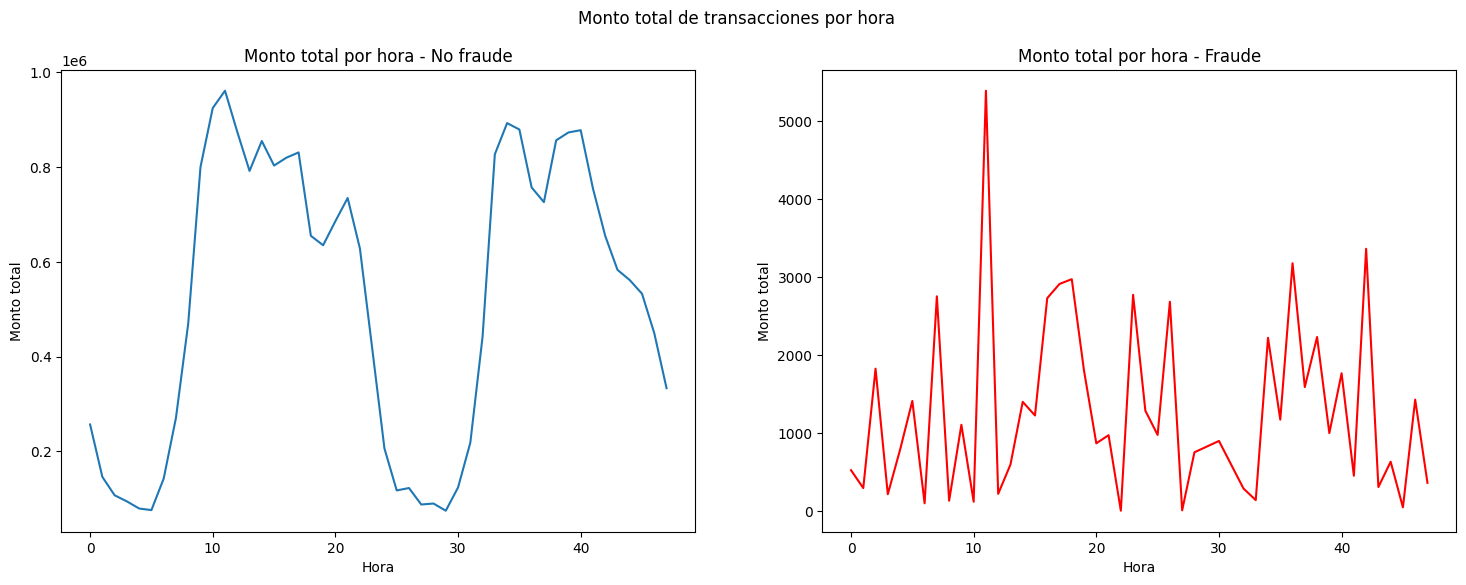

In [13]:
# Creación de dos subgráficos para comparar ambas clases
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))

# Línea para transacciones no fraudulentas (Clase 0)
sns.lineplot(ax=ax1, x="Hour", y="Sum", data=df.loc[df.Class == 0])
ax1.set_title("Monto total por hora - No fraude")
ax1.set_xlabel("Hora")
ax1.set_ylabel("Monto total")

# Línea para transacciones fraudulentas (Clase 1)
sns.lineplot(ax=ax2, x="Hour", y="Sum", data=df.loc[df.Class == 1], color="red")
ax2.set_title("Monto total por hora - Fraude")
ax2.set_xlabel("Hora")
ax2.set_ylabel("Monto total")

# Título general de la figura
plt.suptitle("Monto total de transacciones por hora")

plt.show()


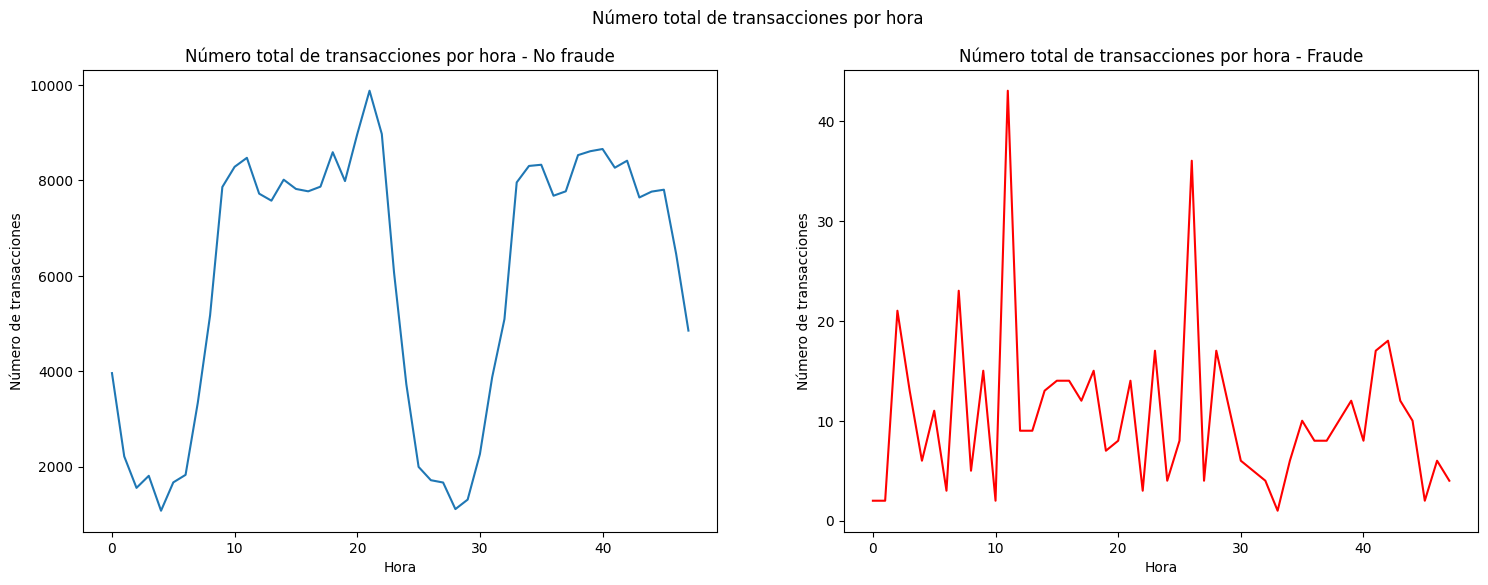

In [14]:
# Creación de dos subgráficos para comparar el número de transacciones por clase
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))

# Número de transacciones por hora - No fraude (Clase 0)
sns.lineplot(ax=ax1, x="Hour", y="Transactions", data=df.loc[df.Class == 0])
ax1.set_title("Número total de transacciones por hora - No fraude")
ax1.set_xlabel("Hora")
ax1.set_ylabel("Número de transacciones")

# Número de transacciones por hora - Fraude (Clase 1)
sns.lineplot(ax=ax2, x="Hour", y="Transactions", data=df.loc[df.Class == 1], color="red")
ax2.set_title("Número total de transacciones por hora - Fraude")
ax2.set_xlabel("Hora")
ax2.set_ylabel("Número de transacciones")

# Título general de la figura
plt.suptitle("Número total de transacciones por hora")

plt.show()


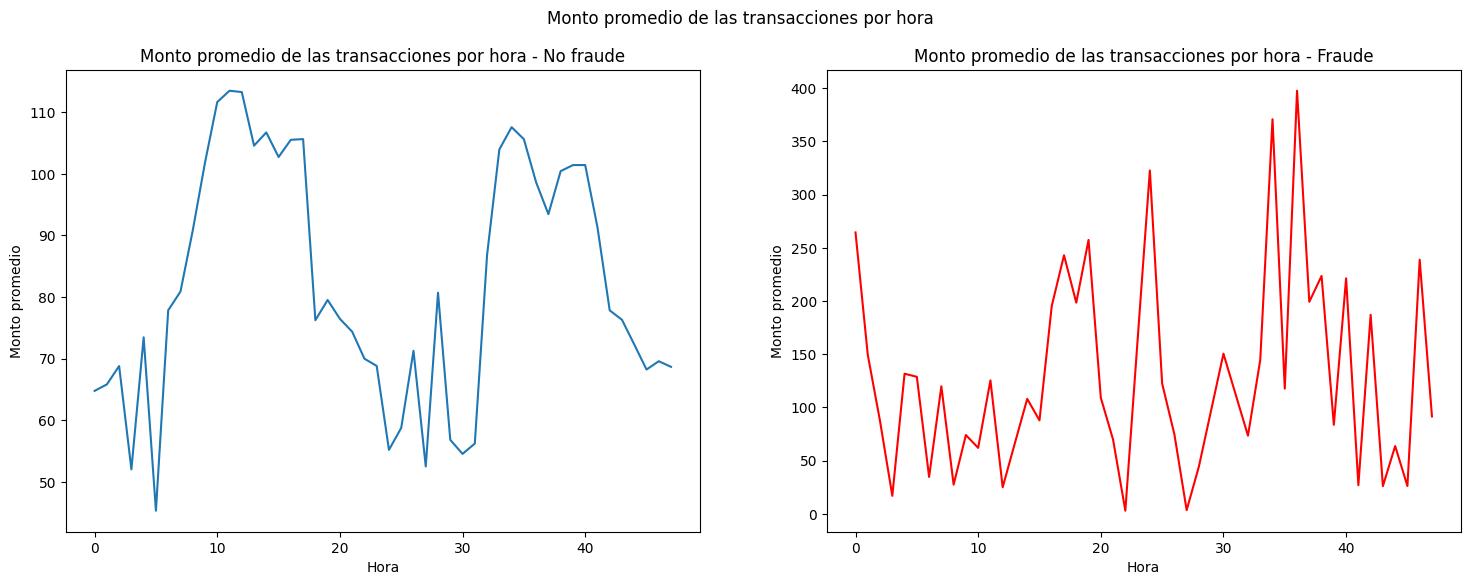

In [15]:
# Creación de dos subgráficos para comparar el monto promedio de las transacciones por clase
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))

# Monto promedio por hora - No fraude (Clase 0)
sns.lineplot(ax=ax1, x="Hour", y="Mean", data=df.loc[df.Class == 0])
ax1.set_title("Monto promedio de las transacciones por hora - No fraude")
ax1.set_xlabel("Hora")
ax1.set_ylabel("Monto promedio")

# Monto promedio por hora - Fraude (Clase 1)
sns.lineplot(ax=ax2, x="Hour", y="Mean", data=df.loc[df.Class == 1], color="red")
ax2.set_title("Monto promedio de las transacciones por hora - Fraude")
ax2.set_xlabel("Hora")
ax2.set_ylabel("Monto promedio")

# Título general de la figura
plt.suptitle("Monto promedio de las transacciones por hora")

plt.show()


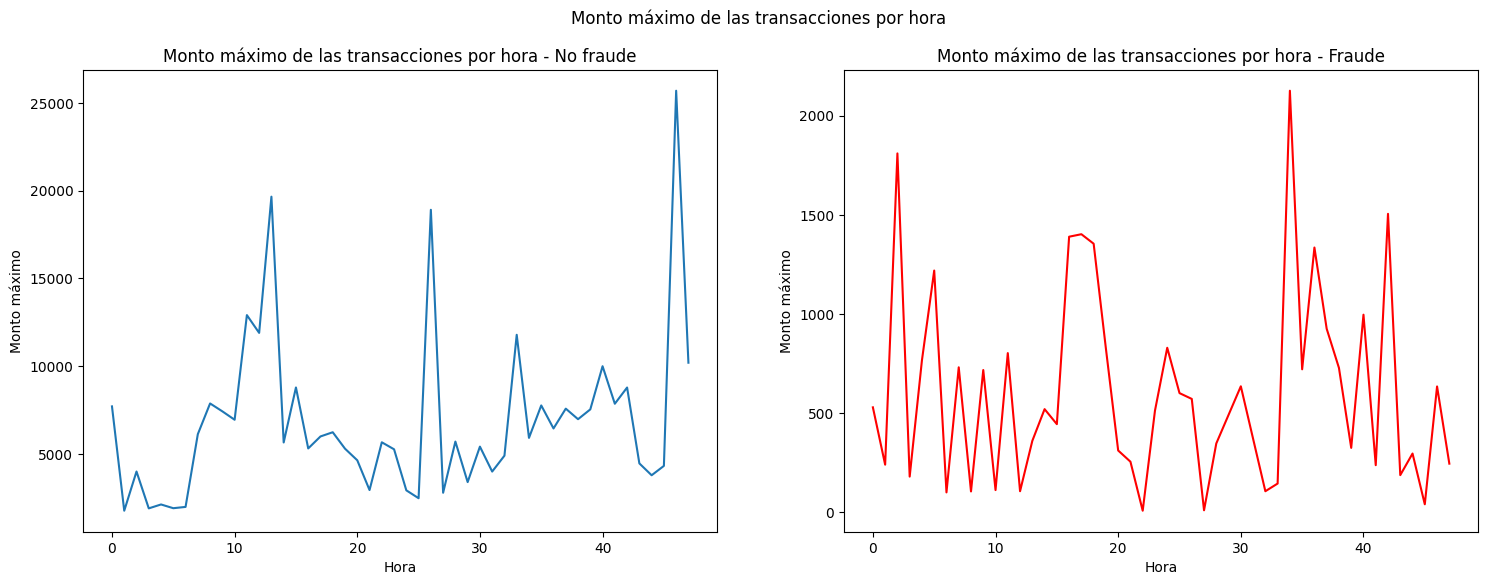

In [16]:
# Creación de dos subgráficos para comparar el monto máximo de las transacciones por clase
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))

# Monto máximo por hora - No fraude (Clase 0)
sns.lineplot(ax=ax1, x="Hour", y="Max", data=df.loc[df.Class == 0])
ax1.set_title("Monto máximo de las transacciones por hora - No fraude")
ax1.set_xlabel("Hora")
ax1.set_ylabel("Monto máximo")

# Monto máximo por hora - Fraude (Clase 1)
sns.lineplot(ax=ax2, x="Hour", y="Max", data=df.loc[df.Class == 1], color="red")
ax2.set_title("Monto máximo de las transacciones por hora - Fraude")
ax2.set_xlabel("Hora")
ax2.set_ylabel("Monto máximo")

# Título general de la figura
plt.suptitle("Monto máximo de las transacciones por hora")

plt.show()

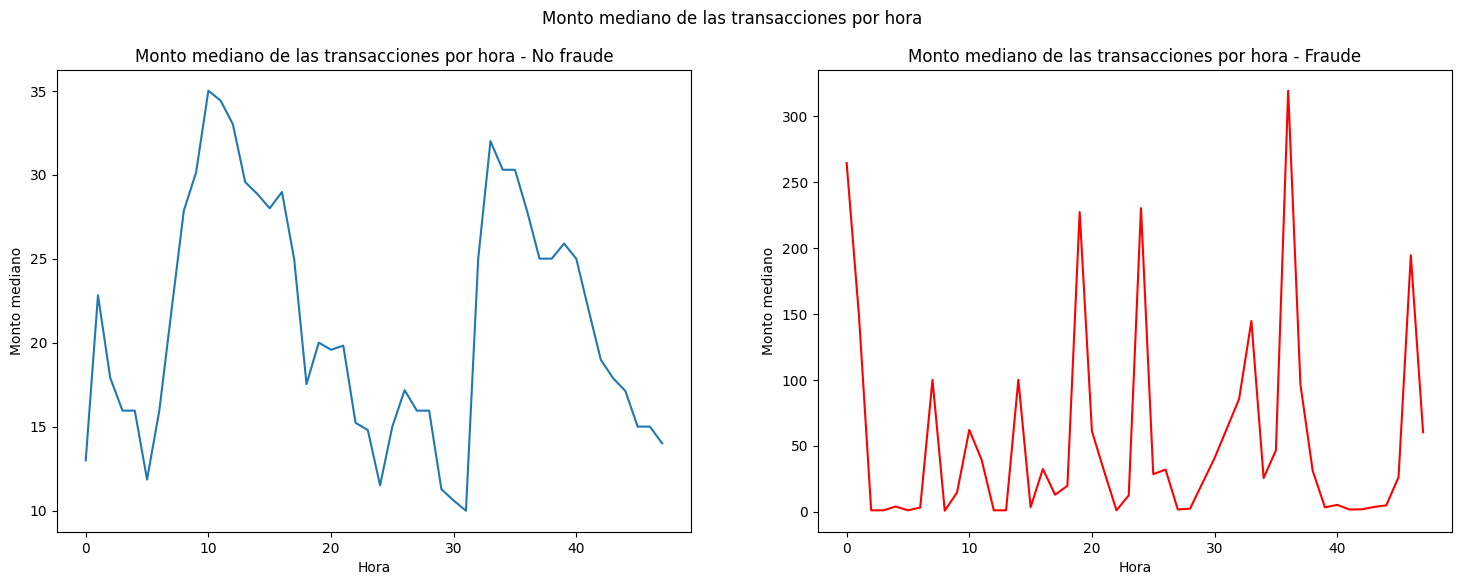

In [17]:
# Creación de dos subgráficos para comparar el monto mediano de las transacciones por clase
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))

# Monto mediano por hora - No fraude (Clase 0)
sns.lineplot(ax=ax1, x="Hour", y="Median", data=df.loc[df.Class == 0])
ax1.set_title("Monto mediano de las transacciones por hora - No fraude")
ax1.set_xlabel("Hora")
ax1.set_ylabel("Monto mediano")

# Monto mediano por hora - Fraude (Clase 1)
sns.lineplot(ax=ax2, x="Hour", y="Median", data=df.loc[df.Class == 1], color="red")
ax2.set_title("Monto mediano de las transacciones por hora - Fraude")
ax2.set_xlabel("Hora")
ax2.set_ylabel("Monto mediano")

# Título general de la figura
plt.suptitle("Monto mediano de las transacciones por hora")

plt.show()


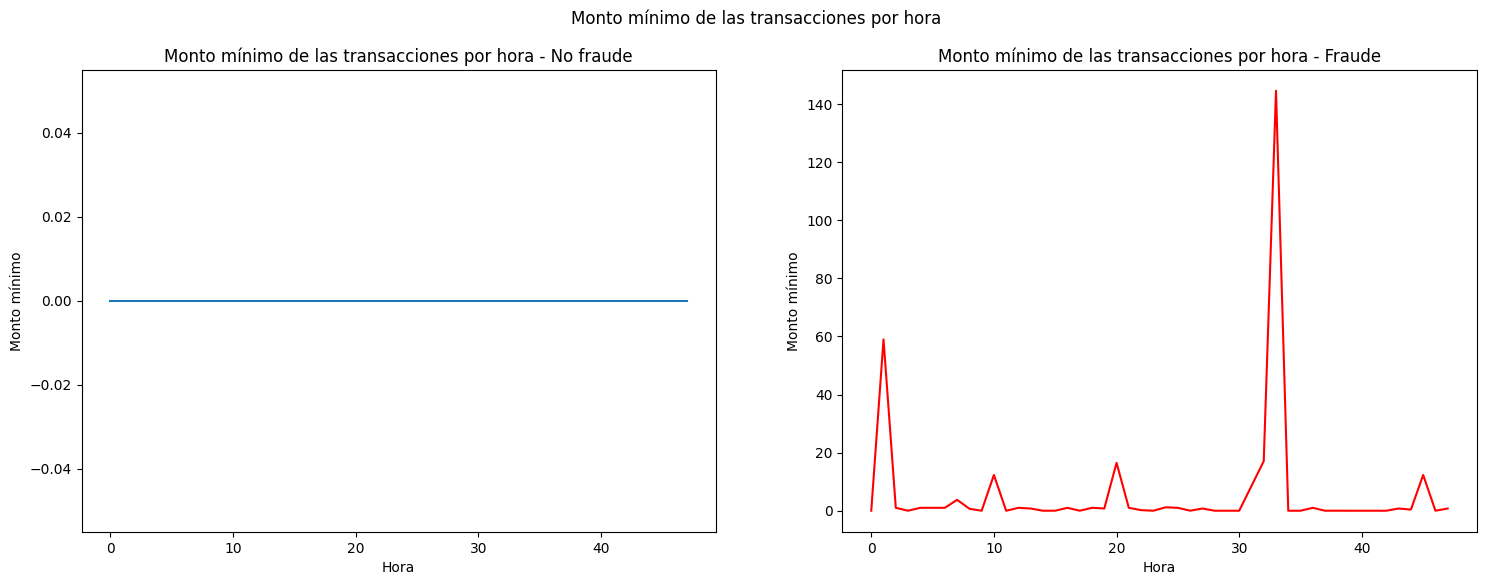

In [18]:
# Creación de dos subgráficos para comparar el monto mínimo de las transacciones por clase
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))

# Monto mínimo por hora - No fraude (Clase 0)
sns.lineplot(ax=ax1, x="Hour", y="Min", data=df.loc[df.Class == 0])
ax1.set_title("Monto mínimo de las transacciones por hora - No fraude")
ax1.set_xlabel("Hora")
ax1.set_ylabel("Monto mínimo")

# Monto mínimo por hora - Fraude (Clase 1)
sns.lineplot(ax=ax2, x="Hour", y="Min", data=df.loc[df.Class == 1], color="red")
ax2.set_title("Monto mínimo de las transacciones por hora - Fraude")
ax2.set_xlabel("Hora")
ax2.set_ylabel("Monto mínimo")

# Título general de la figura
plt.suptitle("Monto mínimo de las transacciones por hora")

plt.show()


## Monto de las transacciones


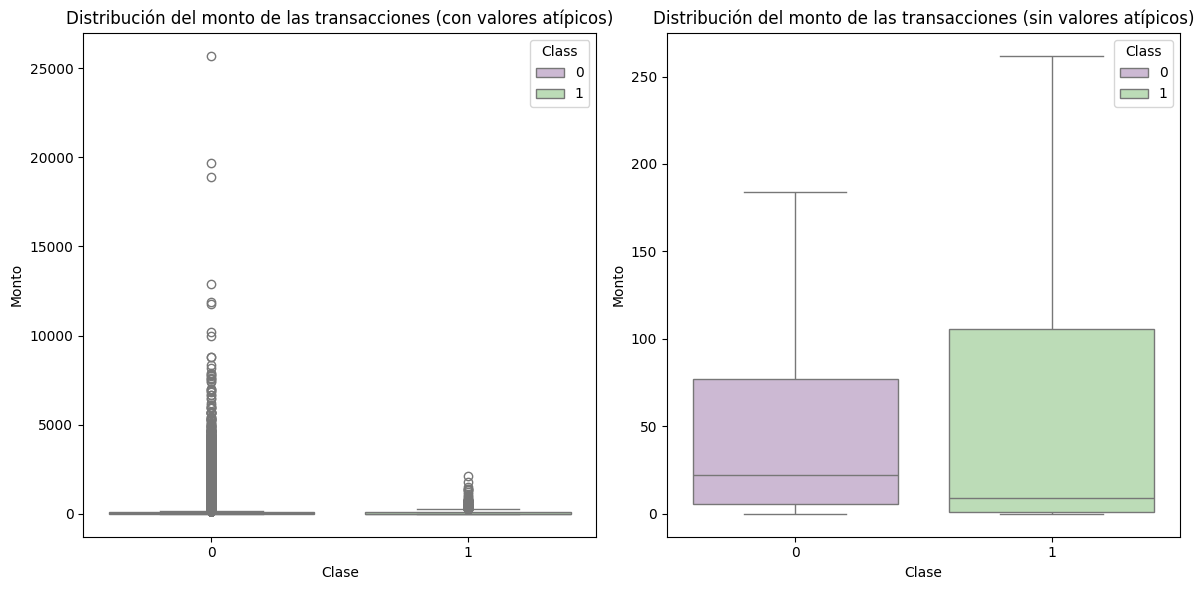

In [19]:
# Creación de dos boxplots para analizar la distribución del monto de las transacciones
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

# Boxplot con valores atípicos (outliers)
sns.boxplot(
    ax=ax1,
    x="Class",
    y="Amount",
    hue="Class",
    data=data_df,
    palette="PRGn",
    showfliers=True
)
ax1.set_title("Distribución del monto de las transacciones (con valores atípicos)")
ax1.set_xlabel("Clase")
ax1.set_ylabel("Monto")

# Boxplot sin valores atípicos
sns.boxplot(
    ax=ax2,
    x="Class",
    y="Amount",
    hue="Class",
    data=data_df,
    palette="PRGn",
    showfliers=False
)
ax2.set_title("Distribución del monto de las transacciones (sin valores atípicos)")
ax2.set_xlabel("Clase")
ax2.set_ylabel("Monto")

# Ajuste de diseño
plt.tight_layout()
plt.show()


In [20]:
tmp = data_df[['Amount','Class']].copy()
class_0 = tmp.loc[tmp['Class'] == 0]['Amount']
class_1 = tmp.loc[tmp['Class'] == 1]['Amount']
class_0.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [21]:
class_1.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Las transacciones reales presentan un valor medio más alto, un Q1 mayor, un Q3 y Q4 más pequeños y valores atípicos de mayor magnitud; en contraste, las transacciones fraudulentas tienen un Q1 y una media menores, un Q4 mayor y valores atípicos más pequeños.

A continuación, representemos gráficamente las transacciones fraudulentas (monto) en función del tiempo. El tiempo se expresa en segundos desde el inicio del período analizado (un total de 48 horas, distribuidas en 2 días).


In [22]:
# Filtrado de las transacciones fraudulentas (Clase 1)
fraud = data_df.loc[data_df['Class'] == 1]

# Gráfico de dispersión del monto de las transacciones fraudulentas en el tiempo
trace = go.Scatter(
    x=fraud['Time'],
    y=fraud['Amount'],
    name="Monto",
    marker=dict(
        color='rgb(238,23,11)',
        line=dict(
            color='red',
            width=1
        ),
        opacity=0.5,
    ),
    text=fraud['Amount'],
    mode="markers"
)

data = [trace]

# Configuración del diseño del gráfico
layout = dict(
    title='Monto de las transacciones fraudulentas',
    xaxis=dict(title='Tiempo [s]', showticklabels=True),
    yaxis=dict(title='Monto'),
    hovermode='closest'
)

# Creación y visualización del gráfico
fig = dict(data=data, layout=layout)
iplot(fig, filename='fraud-amount')



### Conclusión principal

Las transacciones fraudulentas se distribuyen de manera homogénea a lo largo del tiempo y se concentran mayoritariamente en montos bajos, con la presencia ocasional de valores atípicos elevados. No existe un patrón temporal simple que permita distinguir el fraude únicamente a partir del tiempo o del monto, lo que refuerza la necesidad de modelos multivariados para su detección.

---

## Recomendación analítica (siguiente paso lógico)

Para fortalecer el modelo de detección de fraude, se recomienda:

- Combinar las variables **Time**, **Amount** y las variables transformadas (**V1–V28**).
- Crear *features* temporales, como **hora del día** y **periodos noche/día**.
- Aplicar modelos robustos frente al desbalance de clases, tales como:
  - Random Forest
  - Gradient Boosting
  - XGBoost / LightGBM
- Evaluar el desempeño del modelo utilizando métricas adecuadas para datos desbalanceados, como:
  - **ROC-AUC**
  - **Recall** de la clase fraudulenta

---


## Correlación de variables


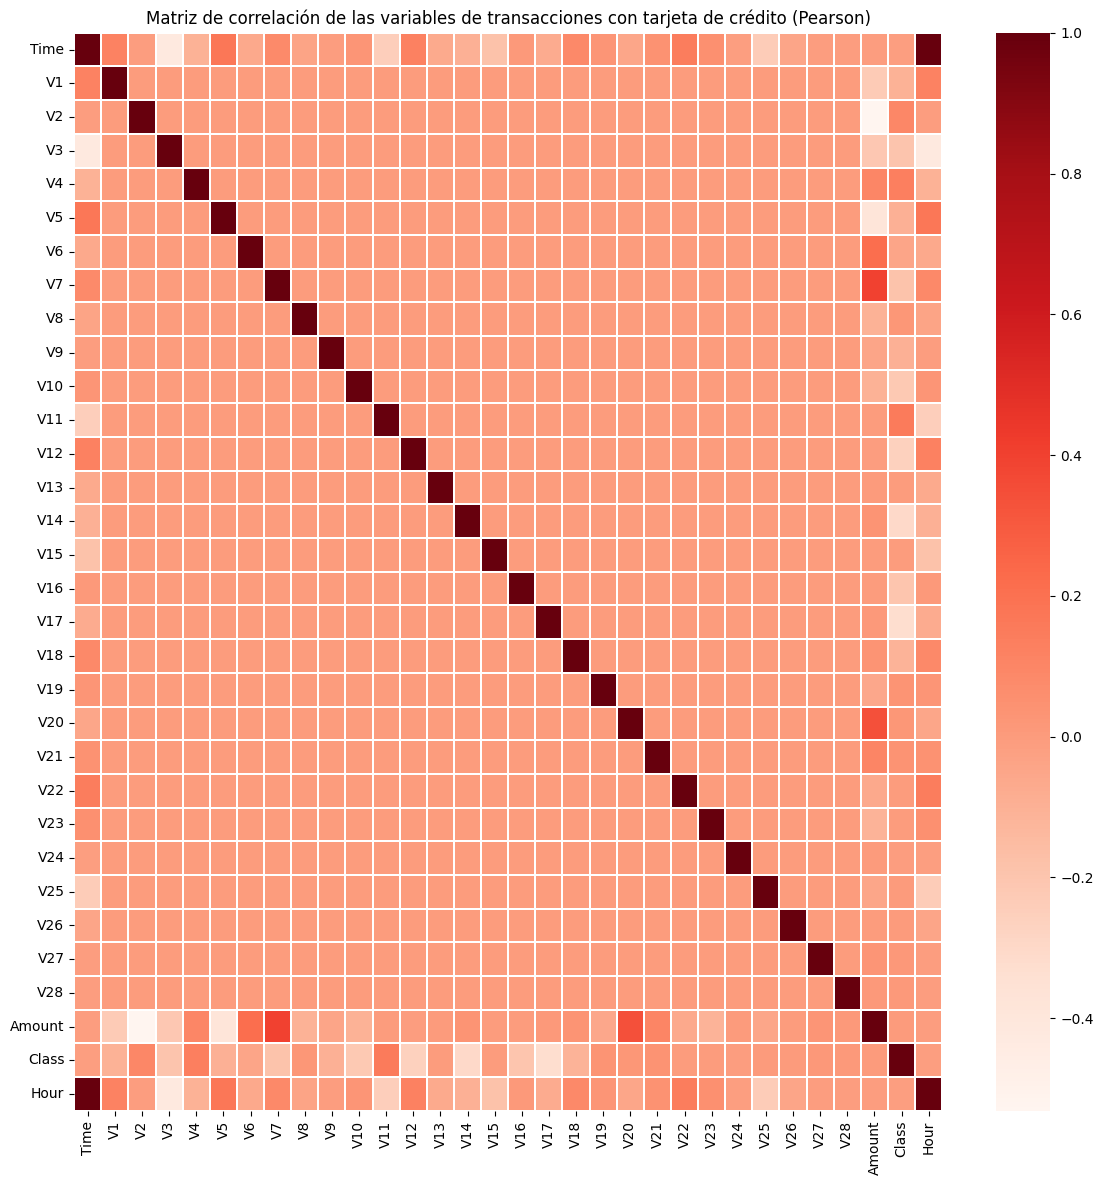

In [23]:
# Configuración del tamaño de la figura
plt.figure(figsize=(14, 14))

# Título del gráfico de correlación
plt.title('Matriz de correlación de las variables de transacciones con tarjeta de crédito (Pearson)')

# Cálculo de la matriz de correlación
corr = data_df.corr()

# Visualización de la matriz de correlación mediante un mapa de calor
sns.heatmap(
    corr,
    xticklabels=corr.columns,
    yticklabels=corr.columns,
    linewidths=.1,
    cmap="Reds"
)

plt.show()


Como se esperaba, no existe una correlación notable entre las características **V1**–**V28**. Existen ciertas correlaciones entre algunas de estas características y **Time** (correlación inversa con **V3**) y **Amount** (correlación directa con **V7** y **V20**, y correlación inversa con **V1** y **V5**).

Ahora, grafiquemos los valores correlacionados y los inversamente correlacionados en el mismo gráfico.

Comencemos con los valores directamente correlacionados: **{V20; Amount}** y **{V7; Amount}**.


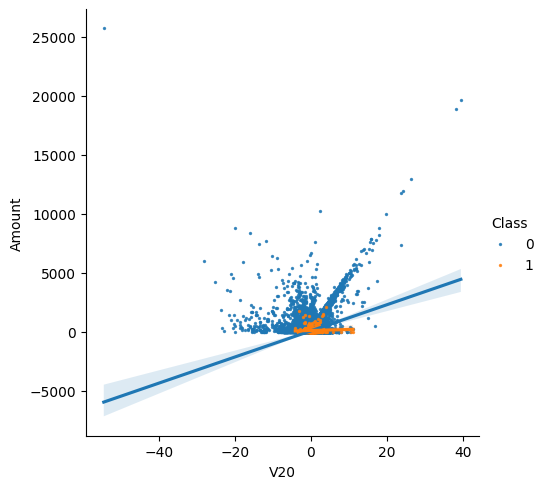

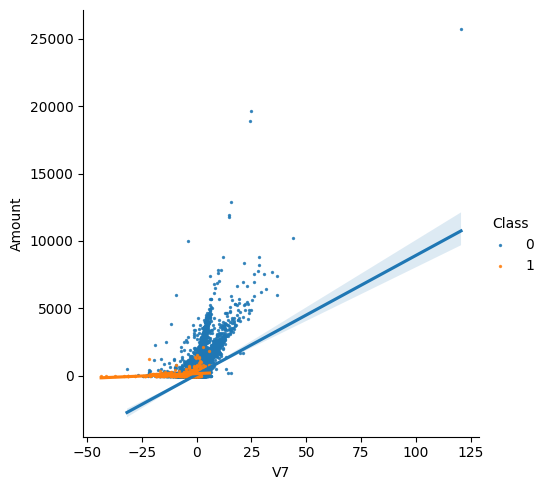

In [24]:
# Gráfico de regresión entre V20 y Amount
# Se analiza la correlación directa entre la característica V20 y el monto de la transacción,
# diferenciando entre transacciones fraudulentas y no fraudulentas (Class)
s = sns.lmplot(x='V20', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
# Gráfico de regresión entre V7 y Amount
# Se analiza la correlación directa entre la característica V7 y el monto de la transacción,
# separando nuevamente por tipo de transacción (fraude / no fraude)
s = sns.lmplot(x='V7', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

Podemos confirmar que ambos pares de características están correlacionados (las líneas de regresión para **Class = 0** presentan una pendiente positiva, mientras que la línea de regresión para **Class = 1** presenta una pendiente positiva menor).

Ahora grafiquemos los valores inversamente correlacionados.



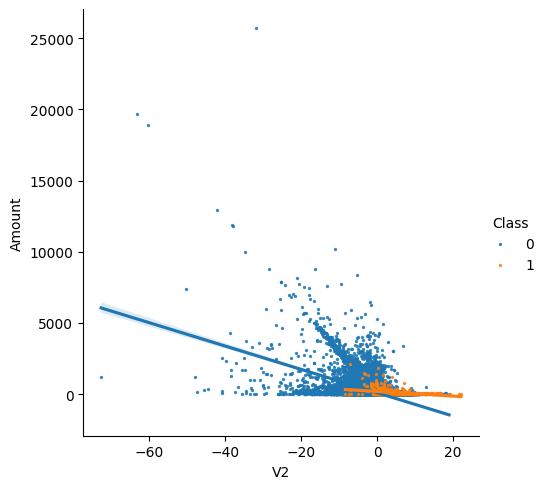

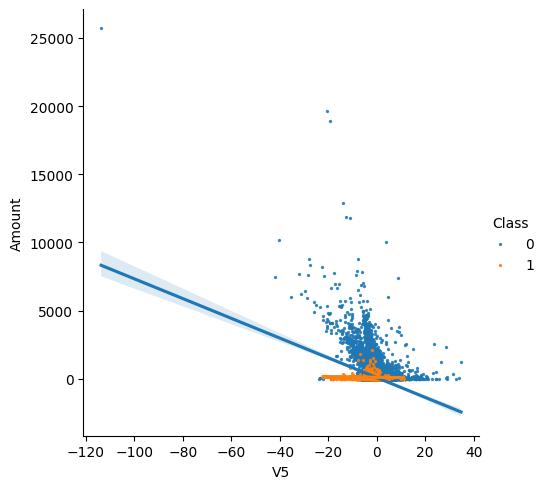

In [26]:
# Gráfico de regresión entre V2 y Amount
# Se analiza la correlación inversa entre la variable V2 y el monto de la transacción,
# diferenciando entre transacciones fraudulentas (Class = 1) y no fraudulentas (Class = 0)

s = sns.lmplot(
    x='V2',
    y='Amount',
    data=data_df,
    hue='Class',         # Separación por clase de transacción
    fit_reg=True,        # Ajuste de la línea de regresión
    scatter_kws={'s': 2} # Tamaño reducido de los puntos para facilitar la visualización
)
# Gráfico de regresión entre V5 y Amount
# Se evalúa la correlación inversa entre la variable V5 y el monto de la transacción,
# observando diferencias en el comportamiento entre fraude y no fraude
s = sns.lmplot(x='V5', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

Podemos confirmar que ambos pares de variables presentan una **correlación inversa** (las líneas de regresión para **Class = 0** tienen una pendiente negativa, mientras que las líneas de regresión para **Class = 1** presentan una pendiente negativa muy pequeña).



## Gráfico de densidad de características


<Figure size 640x480 with 0 Axes>

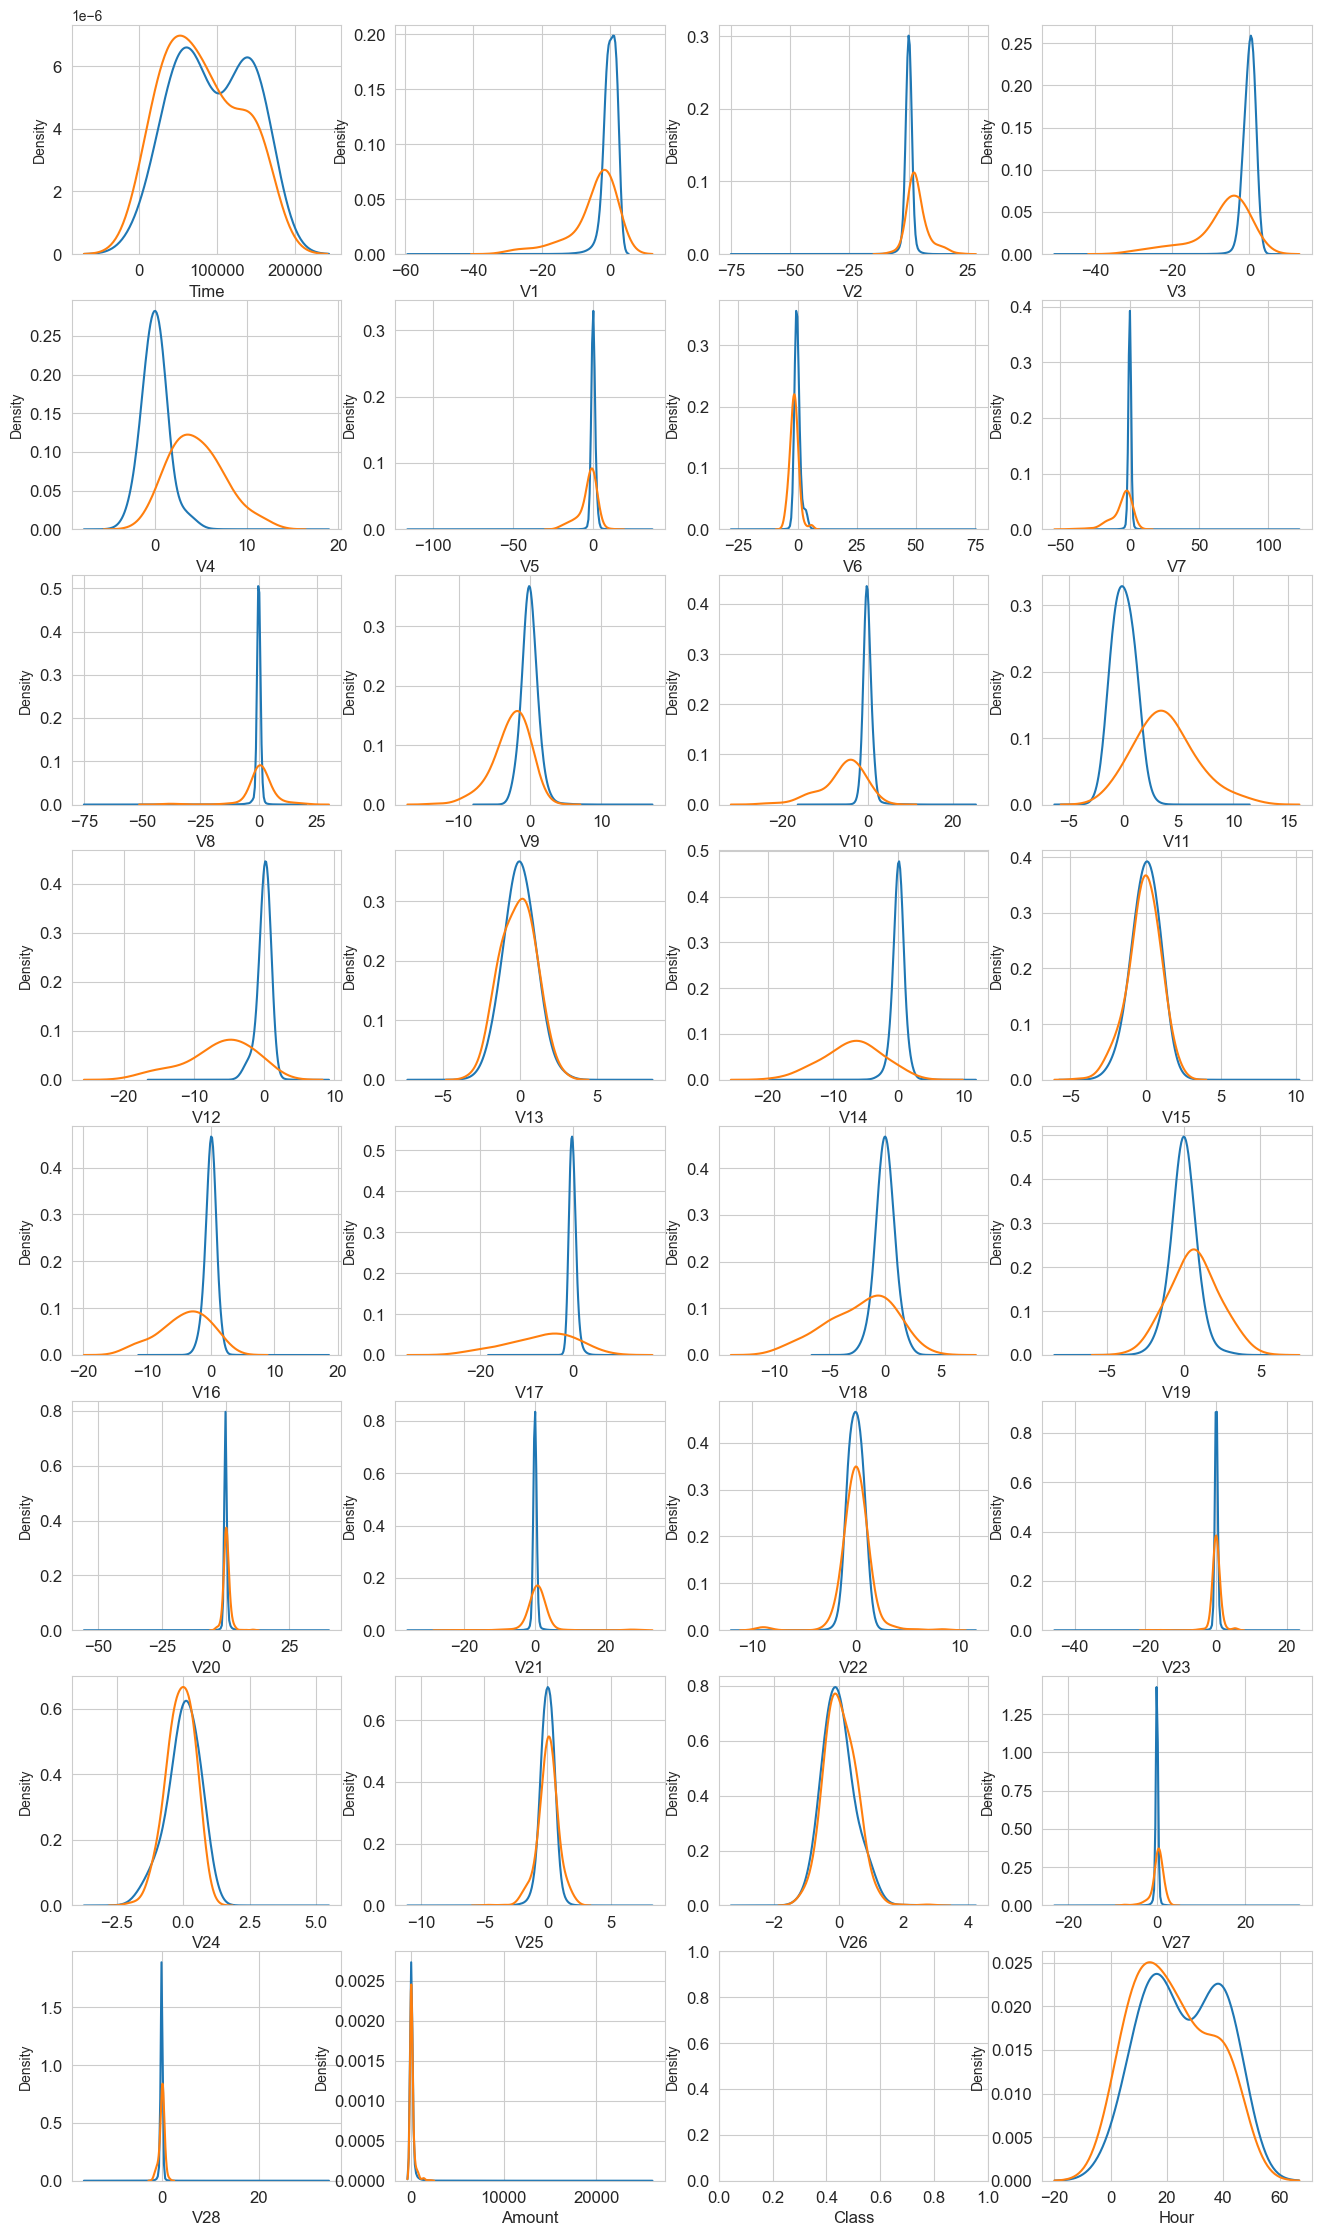

In [28]:
import warnings
warnings.filterwarnings("ignore")
# Lista de variables (columnas) del dataset
variables = data_df.columns.values

# Contador para posicionar subgráficos
i = 0

# Separación del dataset por clase
# Clase 0: transacciones legítimas
# Clase 1: transacciones fraudulentas
transacciones_legitimas = data_df.loc[data_df['Class'] == 0]
transacciones_fraude = data_df.loc[data_df['Class'] == 1]

# Estilo del gráfico
sns.set_style('whitegrid')

# Creación de la figura y la grilla de subgráficos
plt.figure()
fig, ax = plt.subplots(8, 4, figsize=(16, 28))

# Gráficos de densidad (KDE) para cada variable
for feature in variables:
    i += 1
    plt.subplot(8, 4, i)

    # Distribución de densidad para transacciones legítimas
    sns.kdeplot(
        transacciones_legitimas[feature],
        bw=0.5,
        label="Clase = 0 (No Fraude)"
    )

    # Distribución de densidad para transacciones fraudulentas
    sns.kdeplot(
        transacciones_fraude[feature],
        bw=0.5,
        label="Clase = 1 (Fraude)"
    )

    # Etiqueta del eje X
    plt.xlabel(feature, fontsize=12)

    # Configuración de tamaño de etiquetas
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)

# Mostrar todos los gráficos
plt.show()


### Análisis de Variables y su Capacidad de Discriminación

Al analizar cómo se distribuyen los datos según la variable **Class** (0 para transacciones legítimas y 1 para fraudes), se identifican tres comportamientos clave:

* **Variables de alta capacidad predictiva:** Las variables **V4** y **V11** son las mejores para diferenciar fraudes, ya que sus distribuciones están totalmente separadas. **V12**, **V14** y **V18** también muestran una separación importante.
* **Variables con perfiles distintos:** **V1**, **V2**, **V3** y **V10** muestran formas muy diferentes entre clases, lo que ayuda al modelo a distinguir patrones.
* **Variables poco útiles:** **V25**, **V26** y **V28** se ven casi iguales para ambos tipos de transacciones, por lo que aportan poco valor para separar el fraude.

**Patrón General:**
* Las **transacciones legítimas (Class 0)** suelen estar concentradas (centradas en 0) y son simétricas.
* Las **transacciones fraudulentas (Class 1)** suelen ser asimétricas (sesgadas), lo que significa que sus valores tienden a dispersarse hacia un extremo.

*Nota: Las variables **Time** y **Amount** no siguen el patrón de estar centradas en cero y requieren un tratamiento distinto.*

# <a id="6">Modelos predictivos</a>


### Definir predictores y valores objetivo

Vamos a definir las variables predictoras y la variable objetivo. También se definen las variables categóricas, si las hubiera. En nuestro caso, no hay variables categóricas.

In [33]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

### Dividir los datos en conjuntos de entrenamiento, prueba y validación

Vamos a definir los conjuntos de entrenamiento, validación y prueba.

In [29]:
# Configuración de parámetros:
# TEST_SIZE = 0.20: Se reserva el 20% de los datos para la evaluación final. 
# Es el estándar para tener suficientes ejemplos de prueba sin sacrificar mucho entrenamiento.


# VALID_SIZE = 0.20: Del conjunto que quedó para entrenamiento, se toma un 20% adicional 
# para validación (ajuste de parámetros antes de la prueba final).


# RANDOM_STATE = 2018: Es una "semilla" de aleatoriedad. Asegura que cada vez que corras 
# el código, la división sea EXACTAMENTE la misma, permitiendo que tus resultados sean replicables.


train_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

Comencemos con un modelo **RandomForestClassifier** <a href='#8'>[3]</a>.

## <a id="61">RandomForestClassifier</a>

### Definir los parámetros del modelo

Vamos a configurar los parámetros para el modelo.

Ejecutaremos el modelo utilizando el conjunto de entrenamiento para el aprendizaje. Posteriormente, utilizaremos el conjunto de validación para la validación del modelo.

Utilizaremos como criterio de validación **GINI**, cuya fórmula es **GINI = 2 * (AUC) - 1**, donde **AUC** es el **Área Bajo la Curva de la Característica Operativa del Receptor (ROC-AUC)** <a href='#8'>[4]</a>. El número de estimadores se establece en **100** y el número de trabajos en paralelo se fija en **4**.

Comenzamos inicializando el RandomForestClassifier.

In [30]:
# 1. n_jobs: Define el número de núcleos del procesador a usar. Al ser 4, 
#    el entrenamiento es más veloz porque construye árboles en paralelo.
# 2. random_state: Asegura la reproducibilidad. El modelo siempre se dividirá 
#    y se entrenará de la misma forma cada vez que ejecutes la celda.
# 3. criterion: Es la regla matemática ('gini') para medir qué tan bien se 
#    están separando las clases (fraude vs legítimo) en cada nodo del árbol.
# 4. n_estimators: Define que el bosque tendrá 100 árboles de decisión. 
#    Más árboles suelen dar mayor estabilidad y precisión al modelo.
# 5. verbose: Al estar en False (o 0), evita que se impriman mensajes de 
#    seguimiento innecesarios durante el proceso de entrenamiento.

clf = RandomForestClassifier(
    n_jobs=NO_JOBS, 
    random_state=RANDOM_STATE,
    criterion=RFC_METRIC,
    n_estimators=NUM_ESTIMATORS,
    verbose=False
)

Vamos a entrenar el **RandomForestClassifier** utilizando los datos de **train_df** y la función **fit**.

In [34]:
clf.fit(train_df[predictors], train_df[target].values)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Ahora vamos a predecir los valores de la variable **target** para los datos de **valid_df**, utilizando la función **predict**.

In [35]:
preds = clf.predict(valid_df[predictors])

Vamos también a visualizar la importancia de las variables (features importance).

### Importancia de las variables

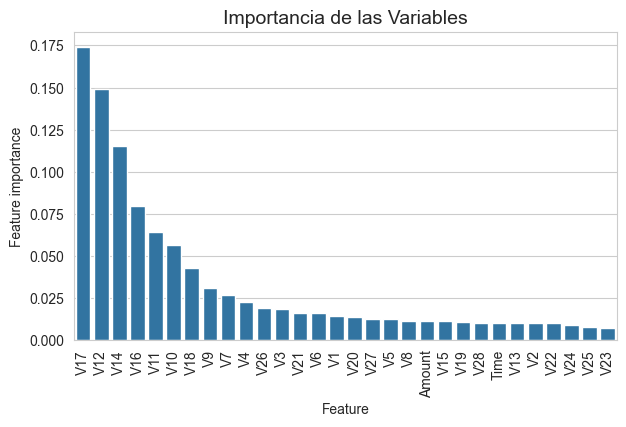

In [36]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance', ascending=False)

plt.figure(figsize=(7,4))
plt.title('Importancia de las Variables', fontsize=14)
s = sns.barplot(x='Feature', y='Feature importance', data=tmp)
s.set_xticklabels(s.get_xticklabels(), rotation=90)
plt.show()


Las variables más importantes son **V17**, **V12**, **V14**, **V10**, **V11** y **V16**.

### Matriz de confusión

Vamos a mostrar una matriz de confusión para los resultados obtenidos.

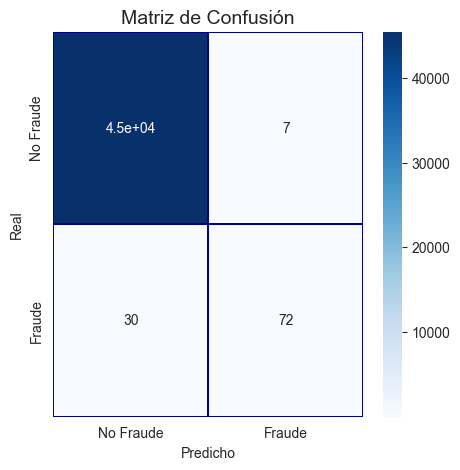

In [37]:
# Generar la tabla cruzada entre los valores reales y las predicciones
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Real'], colnames=['Predicho'])

# Configurar el lienzo de la gráfica
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))

# Crear el mapa de calor con Seaborn
sns.heatmap(cm, 
            xticklabels=['No Fraude', 'Fraude'], # Etiquetas eje X
            yticklabels=['No Fraude', 'Fraude'], # Etiquetas eje Y
            annot=True,                          # Mostrar los números en las celdas
            ax=ax1,
            linewidths=.2,                       # Espaciado entre celdas
            linecolor="Darkblue",                # Color de las líneas divisorias
            cmap="Blues")                        # Gama de colores azules

plt.title('Matriz de Confusión', fontsize=14)
plt.show()

### Conclusión: Análisis de la Matriz de Confusión

La matriz de confusión es la herramienta fundamental en este proyecto. En un problema de detección de fraude, los datos están **altamente desbalanceados** (hay miles de transacciones legítimas por cada fraude), por lo que el "Accuracy" o precisión global suele ser engañoso.

#### 1. Análisis de los resultados (Tu Matriz)
Al observar los cuadrantes de la matriz, identificamos el rendimiento real del modelo:

* **Verdaderos Negativos (TN) [~45,000]:** El modelo identifica casi a la perfección las transacciones legítimas.
* **Falsos Positivos (Error Tipo I) [7]:** Representan "Falsas Alarmas". Solo 7 clientes fueron molestados por un error del sistema. Esto indica una **Precisión** muy alta.
* **Verdaderos Positivos (TP) [72]:** El modelo logró detectar con éxito 72 fraudes reales.
* **Falsos Negativos (Error Tipo II) [30]:** Este es el punto crítico. Hubo **30 fraudes que el modelo no detectó**. Estos casos representan la pérdida económica real para el banco.

#### 2. ¿Por qué es vital esta matriz para el problema de Fraude?

En la detección de fraude, la importancia de la matriz de confusión radica en tres puntos clave:

1.  **Desmitifica la Precisión Global:** Si tuviéramos un modelo que dijera siempre que "No es Fraude", tendría una precisión del 99.9%, pero no detectaría ningún robo. La matriz nos obliga a ver la efectividad sobre la clase minoritaria (**Fraude**).
2.  **Identifica el Costo del Error:** En este negocio, el **Error Tipo II (Falso Negativo)** es mucho más costoso que el Error Tipo I. Es preferible llamar a un cliente para verificar una compra (Tipo I) que permitir que un criminal gaste dinero (Tipo II).
3.  **Evaluación de la Sensibilidad (Recall):** Tu matriz muestra que estás capturando aproximadamente el **70.5%** de los fraudes ($72 / 102$). La matriz nos indica claramente que hay un margen de mejora para reducir esos 30 fraudes que se escaparon.


-------

### Error de Tipo I y Error de Tipo II

Es importante aclarar que la **matriz de confusión** por sí sola no es la mejor herramienta cuando los datos están muy desequilibrados (como en este caso, donde hay muy pocos fraudes). Necesitamos métricas que midan al mismo tiempo la **selectividad** y la **especificidad** del modelo para minimizar ambos tipos de errores:

* **Hipótesis Nula ($H_0$):** La transacción **NO** es un fraude (es legítima).
* **Hipótesis Alternativa ($H_1$):** La transacción **SÍ** es un fraude.

---

#### ¿Qué significan estos errores en la vida real?

| Error | Definición Técnica | Explicación Sencilla (Costo) |
| :--- | :--- | :--- |
| **Error de Tipo I** (Falso Positivo) | Rechazas $H_0$ cuando es verdadera. | **Falsa Alarma:** El sistema dice que es fraude, pero era una compra legítima. El cliente se molesta porque le rechazan la tarjeta. |
| **Error de Tipo II** (Falso Negativo) | No rechazas $H_0$ cuando $H_1$ es verdadera. | **Fraude no detectado:** El sistema dice que es legítima, pero era un robo. El banco pierde dinero y el criminal se sale con la suya. |

---

La siguiente imagen ilustra de forma visual la diferencia entre el **Error de Tipo I** y el **Error de Tipo II**:

<img src="https://i.stack.imgur.com/x1GQ1.png" width="600"/>

Y esta imagen alternativa lo explica aún mejor:

<img src="https://i2.wp.com/flowingdata.com/wp-content/uploads/2014/05/Type-I-and-II-errors1.jpg" width="600"/>



Calculemos la puntuación ROC-AUC <a href='#8'>[4]</a>.


### Área bajo la curva

In [38]:
roc_auc_score(valid_df[target].values, preds)

0.8528641975628091





## El puntaje **ROC-AUC** obtenido con el **RandomForestClassifier** es **0.85**.

El puntaje **ROC-AUC** de **0.85** es un resultado sólido. A continuación, desglosamos qué significa este número específicamente para nuestro detector de fraudes:

---

###  ¿Qué nos dice este valor?

* **Capacidad de Discriminación**: Un valor de **0.85** significa que existe un **85% de probabilidad** de que el modelo asigne una puntuación de riesgo más alta a una transacción fraudulenta elegida al azar que a una legítima.
* **Calidad del Modelo**: 
    * **0.5**: Equivale a lanzar una moneda al aire (puro azar).
    * **1.0**: Es un modelo perfecto.
    * **0.85**: Indica un **buen poder predictivo**. El modelo es confiable, aunque queda un 15% de incertidumbre por mejorar.
* **Relación con el Coeficiente GINI**: 
    Utilizando la fórmula de conversión:
    $$Gini = 2 \times AUC - 1$$
    $$Gini = 2 \times 0.85 - 1 = 0.70$$
    Un **0.70** es un indicador de rendimiento **muy respetable** y competitivo en el sector bancario y financiero.

---

###  Visualización de la Curva ROC
La curva ROC nos ayuda a entender el equilibrio entre la **Sensibilidad** (detectar fraudes) y la **Especificidad** (no dar falsas alarmas). Un AUC de 0.85 indica que la curva se desplaza significativamente hacia la esquina superior izquierda, alejándose de la línea de azar.

## <a id="62">AdaBoostClassifier</a>

AdaBoostClassifier significa Clasificador de Impulso Adaptativo (Adaptive Boosting Classifier) <a href='#8'>[5]</a>.

### Preparar el modelo

Vamos a establecer los parámetros para el modelo e inicializarlo.

In [43]:
# 1. n_estimators: Número de modelos débiles (usualmente árboles pequeños) 
#    que se entrenarán secuencialmente. 100 es un buen equilibrio.
# 2. random_state: Garantiza que los resultados sean reproducibles cada vez 
#    que corras el experimento.
# 3. algorithm: 'SAMME' es el algoritmo por defecto que utiliza 
#    probabilidades para actualizar los pesos, siendo más rápido y estable.
# 4. learning_rate: Controla cuánto contribuye cada modelo al resultado final. 
#    Un valor de 0.8 ayuda a evitar el sobreajuste (overfitting).
clf = AdaBoostClassifier(random_state=RANDOM_STATE,
                         algorithm='SAMME',
                         learning_rate=0.8,
                             n_estimators=NUM_ESTIMATORS)

### Entrenar el modelo

Vamos a entrenar el modelo.

In [44]:
clf.fit(train_df[predictors], train_df[target].values)

,estimator,None
,n_estimators,100
,learning_rate,0.8
,algorithm,'SAMME'
,random_state,2018


### Predecir los valores objetivo

Vamos ahora a predecir los valores de la variable **target** para los datos de **valid_df**, utilizando la función `predict`.

In [45]:
preds = clf.predict(valid_df[predictors])

### Importancia de las variables (Features importance)

Veamos también cuáles son las variables más importantes para el modelo.

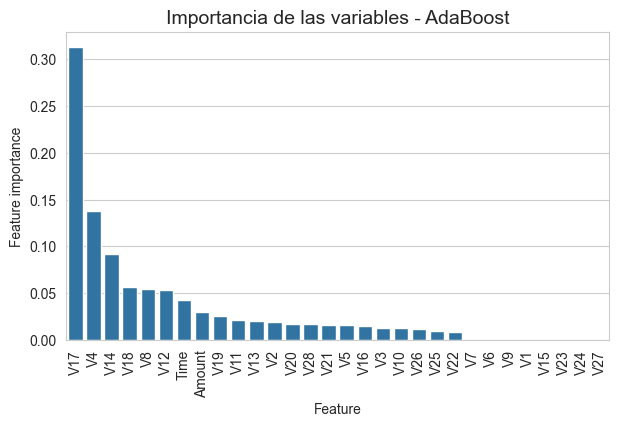

In [46]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance', ascending=False)

plt.figure(figsize=(7,4))
plt.title('Importancia de las variables - AdaBoost', fontsize=14)
s = sns.barplot(x='Feature', y='Feature importance', data=tmp)
s.set_xticklabels(s.get_xticklabels(), rotation=90)
plt.show()

### Matriz de confusión

Vamos a visualizar la matriz de confusión para evaluar el desempeño del modelo AdaBoost.

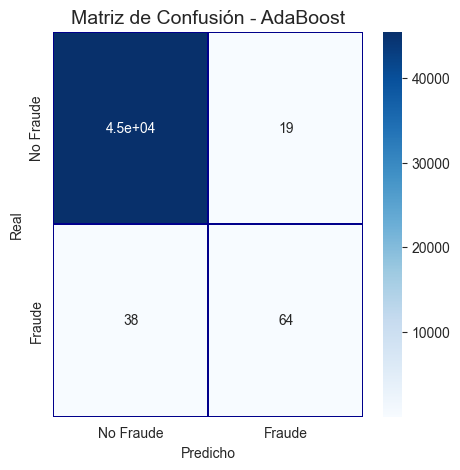

In [47]:
# Creamos la tabla cruzada entre valores reales y predicciones
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Real'], colnames=['Predicho'])

# Configuración del gráfico
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))

sns.heatmap(cm, 
            xticklabels=['No Fraude', 'Fraude'], 
            yticklabels=['No Fraude', 'Fraude'], 
            annot=True, 
            ax=ax1,
            linewidths=.2, 
            linecolor="Darkblue", 
            cmap="Blues")

plt.title('Matriz de Confusión - AdaBoost', fontsize=14)
plt.show()

### Área bajo la curva (ROC-AUC)

Vamos a calcular también el puntaje ROC-AUC para evaluar la capacidad de discriminación del modelo AdaBoost.

In [48]:
roc_auc_score(valid_df[target].values, preds)

0.8135165474463918

La puntuación ROC-AUC obtenida con AdaBoostClassifier es  **0.81**.

## <a id="63">CatBoostClassifier</a>

CatBoostClassifier es un algoritmo de potenciación de gradiente (gradient boosting) sobre árboles de decisión que destaca por su excelente soporte en el manejo de datos categóricos <a href='#8'>[6]</a>.

### Preparar el modelo

Vamos a establecer los parámetros para el modelo e inicializarlo.

###  Configuración del Modelo CatBoost

He configurado el **CatBoostClassifier** con parámetros específicos para maximizar la detección de fraude. Aquí te explico qué hace cada uno:

* **`iterations=500`**: Define el número máximo de árboles que el modelo construirá. Es el límite de pasos en el proceso de aprendizaje.
* **`learning_rate=0.02`**: Es el tamaño del paso de actualización. Un valor pequeño como 0.02 hace que el aprendizaje sea más lento y preciso, ayudando a que el modelo no se "pase de largo" de la solución óptima.
* **`depth=12`**: Determina la profundidad de los árboles. Al ser un valor alto (12), el modelo puede capturar relaciones muy complejas y específicas entre las variables (interacciones de alto nivel).
* **`eval_metric='AUC'`**: Le indica al modelo que use el **Área Bajo la Curva** como brújula para optimizar sus decisiones durante el entrenamiento, ideal para problemas de clasificación binaria desbalanceada.
* **`random_seed=RANDOM_STATE`**: Asegura que el experimento sea reproducible; si corres el código de nuevo, obtendrás los mismos resultados.
* **`bagging_temperature=0.2`**: Controla la intensidad del remuestreo aleatorio. Ayuda a reducir el sobreajuste al permitir que el modelo no sea tan rígido con los datos de entrenamiento.
* **`od_type='Iter'` y `od_wait=100`**: Estos trabajan juntos como un **Detector de Sobreajuste (Overfitting Detector)**. Si el AUC no mejora durante 100 iteraciones consecutivas, el entrenamiento se detiene automáticamente.
* **`metric_period=VERBOSE_EVAL`**: Define cada cuántas iteraciones se mostrarán los resultados en pantalla (por ejemplo, cada 50 o 100 pasos), para no saturar la salida del notebook.

In [50]:


clf = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL,
                             od_wait=100)

In [51]:
clf.fit(train_df[predictors], train_df[target].values,verbose=True)

0:	total: 781ms	remaining: 6m 29s
50:	total: 35.8s	remaining: 5m 15s
100:	total: 1m 10s	remaining: 4m 38s
150:	total: 1m 45s	remaining: 4m 4s
200:	total: 2m 17s	remaining: 3m 24s
250:	total: 2m 48s	remaining: 2m 47s
300:	total: 3m 16s	remaining: 2m 9s
350:	total: 3m 44s	remaining: 1m 35s
400:	total: 4m 11s	remaining: 1m 2s
450:	total: 4m 42s	remaining: 30.7s
499:	total: 5m 13s	remaining: 0us


### Predecir los valores objetivo

Vamos ahora a predecir los valores de la variable **target** para los datos de **valid_df**, utilizando la función `predict`.

In [52]:
preds = clf.predict(valid_df[predictors])

### Importancia de las variables (Features importance)

Veamos también cuáles son las variables más determinantes para el modelo CatBoost.

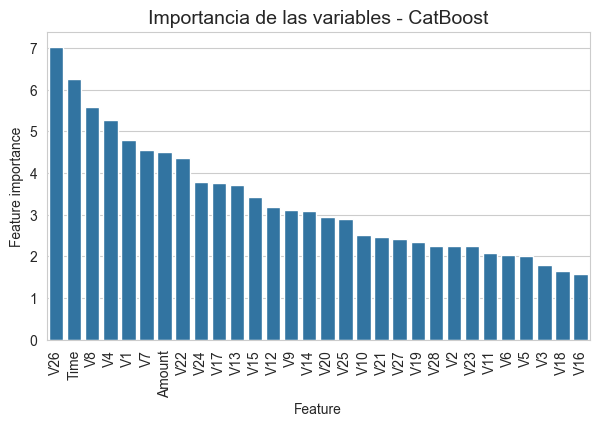

In [53]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.get_feature_importance()})
tmp = tmp.sort_values(by='Feature importance', ascending=False)

plt.figure(figsize=(7,4))
plt.title('Importancia de las variables - CatBoost', fontsize=14)
s = sns.barplot(x='Feature', y='Feature importance', data=tmp)
s.set_xticklabels(s.get_xticklabels(), rotation=90)
plt.show()

### Matriz de confusión

Vamos a visualizar la matriz de confusión para evaluar el desempeño final de nuestro modelo CatBoost.

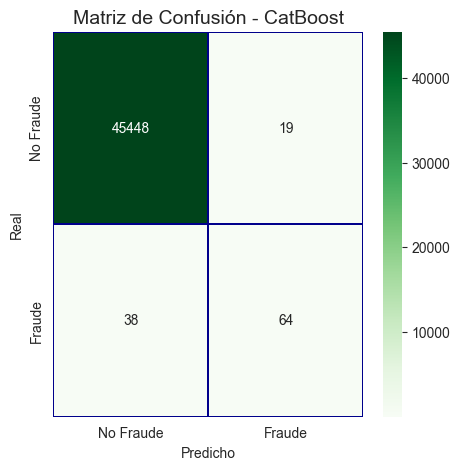

In [54]:
# Configuración visual
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))

sns.heatmap(cm, 
            xticklabels=['No Fraude', 'Fraude'], 
            yticklabels=['No Fraude', 'Fraude'], 
            annot=True, 
            ax=ax1,
            fmt="d", # Formato de número entero
            linewidths=.2, 
            linecolor="Darkblue", 
            cmap="Greens") # Usamos verde para diferenciarlo de AdaBoost

plt.title('Matriz de Confusión - CatBoost', fontsize=14)
plt.show()

### Área bajo la curva (ROC-AUC)

Calculamos la métrica final para determinar si la arquitectura de **CatBoost** y la profundidad de sus árboles lograron superar el rendimiento de los modelos anteriores.

In [55]:
roc_auc_score(valid_df[target].values, preds)

0.8577991493075996

The ROC-AUC score obtained with CatBoostClassifier is **0.85**.

## <a id="64">XGBoost</a>

XGBoost (Extreme Gradient Boosting) es una implementación optimizada de la potenciación de gradiente diseñada para ser altamente eficiente, flexible y portátil <a href='#8'>[7]</a>.

### Preparar el modelo

Vamos a establecer los parámetros para el modelo e inicializarlo.

### Preparar el modelo

Inicializamos los objetos **DMatrix** para el entrenamiento y la validación a partir de los conjuntos de datos. También configuramos algunos de los parámetros que se utilizarán para el ajuste del modelo.

In [56]:
# Convertimos los DataFrames de pandas a objetos DMatrix, el formato interno optimizado de XGBoost
# dtrain: Datos para que el modelo aprenda los patrones de fraude
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)

# dvalid: Datos para ajustar los hiperparámetros y detectar sobreajuste durante el entrenamiento
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)

# dtest: Datos finales totalmente aislados para evaluar el rendimiento real del modelo
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)

# Definimos una lista de monitoreo para observar el rendimiento del AUC en tiempo real
# Esto permite ver si el error baja en 'train' pero sube en 'valid' (indicador de overfitting)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Inicializamos el diccionario de parámetros de configuración
params = {}

# Definimos la tarea: clasificación binaria devolviendo la probabilidad logística
params['objective'] = 'binary:logistic'

# Establecemos la tasa de aprendizaje (encogimiento); controla qué tanto influye cada nuevo árbol
params['eta'] = 0.039

# Desactivamos los mensajes de log internos para mantener la salida del notebook limpia
params['silent'] = True

# Limitamos la profundidad de los árboles a 2 niveles para evitar que el modelo sea demasiado complejo
params['max_depth'] = 2

# Usamos solo el 80% de las filas para cada árbol, añadiendo robustez contra valores atípicos
params['subsample'] = 0.8

# Usamos el 90% de las variables en cada árbol para evitar la dependencia en una sola característica
params['colsample_bytree'] = 0.9

# Establecemos el Área Bajo la Curva (AUC) como la métrica para evaluar la calidad del modelo
params['eval_metric'] = 'auc'

# Fijamos la semilla aleatoria para que los resultados sean exactamente iguales cada vez que se ejecute
params['random_state'] = RANDOM_STATE

### Entrenar el modelo

Vamos a proceder con el entrenamiento del modelo XGBoost utilizando los conjuntos de datos preparados y los parámetros configurados anteriormente.

In [57]:
# Se entrena el modelo usando 1000 rondas máximas (MAX_ROUNDS)
# El progreso se mostrará cada 50 iteraciones (VERBOSE_EVAL)
model = xgb.train(
    params,                        # Configuración técnica (eta, depth, etc.)
    dtrain,                        # Datos de entrenamiento optimizados
    MAX_ROUNDS,                    # Límite de 1000 árboles
    watchlist,                     # Monitoreo de train vs valid en tiempo real
    early_stopping_rounds=EARLY_STOP, # Parada si no mejora tras 50 rondas
    maximize=True,                 # Buscamos el AUC más alto
    verbose_eval=VERBOSE_EVAL      # Reporte cada 50 pasos
)

[0]	train-auc:0.93758	valid-auc:0.88823
[50]	train-auc:0.98295	valid-auc:0.97288
[100]	train-auc:0.99025	valid-auc:0.97831
[127]	train-auc:0.99245	valid-auc:0.97808


El modelo XGBoost ha demostrado ser el más eficiente hasta el momento, logrando un AUC de validación de 0.978 y deteniendo su ejecución automáticamente en la iteración 127; esto indica que, gracias al parámetro early_stopping_rounds, el algoritmo identificó el punto exacto de equilibrio donde maximiza el aprendizaje sin caer en el sobreajuste (overfitting), superando la estabilidad de los modelos previos.

### Visualización de la importancia de las variables

Para entender qué factores están impulsando las predicciones de fraude, graficamos la importancia de las variables. Esto nos permite validar si el modelo está tomando decisiones basadas en patrones financieros lógicos o en ruido.

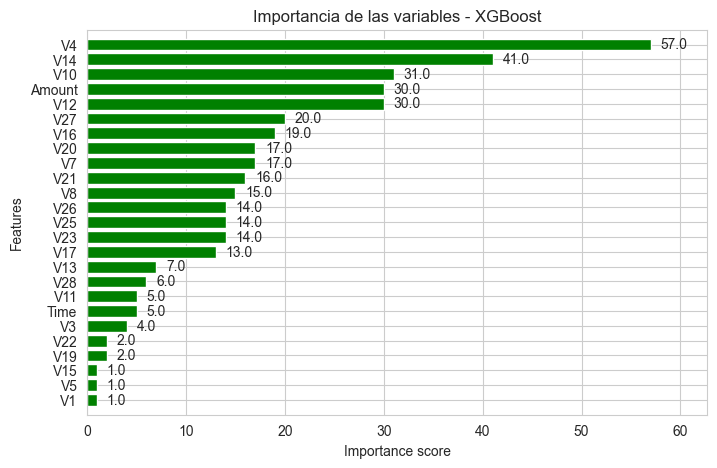

In [59]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Importancia de las variables - XGBoost", ax=ax, color="green") 
plt.show()

### Predicción del conjunto de prueba

Hemos utilizado los conjuntos de entrenamiento y validación para desarrollar y ajustar el modelo. Ahora, utilizaremos el modelo entrenado para predecir los valores del objetivo en el conjunto de prueba, lo que nos dará una visión real de su capacidad de generalización.

In [60]:
preds = model.predict(dtest)

### Área bajo la curva (ROC-AUC)

Calculamos el puntaje ROC-AUC para el conjunto de prueba. Esta métrica es fundamental para confirmar si la capacidad de generalización de XGBoost supera a la de los modelos anteriores en datos que nunca ha visto.

In [61]:
roc_auc_score(test_df[target].values, preds)

0.9719090077732053

## <a id="64">LightGBM</a>

Continuemos con otro algoritmo de potenciación de gradiente: LightGBM <a href='#8'>[8]</a> <a href='#8'>[9]</a>.

### Definir los parámetros del modelo

Establezcamos los parámetros del modelo. Estos parámetros se usarán solo para el primer modelo lgb.

In [62]:
# EXPLICACIÓN DE PARÁMETROS:
# 'boosting_type': Define el algoritmo de entrenamiento (gbdt = Gradient Boosting Decision Tree).
# 'objective': El tipo de tarea; 'binary' indica clasificación binaria (0 o 1).
# 'metric': La métrica de evaluación; 'auc' mide el área bajo la curva ROC.
# 'learning_rate': Tamaño del paso de actualización (0.05); valores bajos requieren más iteraciones pero son más precisos.
# 'num_leaves': Número máximo de hojas en un árbol. Controla la complejidad del modelo.
# 'max_depth': Límite de profundidad de los árboles para evitar el sobreajuste (overfitting).
# 'min_child_samples': Cantidad mínima de datos en una hoja; valores altos evitan que el árbol crezca demasiado.
# 'max_bin': Número máximo de contenedores en los que se agrupan los valores de las características.
# 'subsample': Fracción de datos usada para entrenar cada árbol (90%), ayuda a la generalización.
# 'subsample_freq': Frecuencia con la que se realiza el submuestreo de datos.
# 'colsample_bytree': Porcentaje de columnas (características) seleccionadas al azar para construir cada árbol (70%).
# 'min_child_weight': Suma mínima de la instancia necesaria en un nodo hoja.
# 'min_split_gain': Ganancia mínima necesaria para realizar una partición adicional en un nodo.
# 'nthread': Número de hilos de CPU en paralelo para acelerar el entrenamiento.
# 'verbose': Controla los mensajes de salida (0 significa modo silencioso).
# 'scale_pos_weight': Balancea clases desequilibradas dando más peso a la clase positiva (útil si hay pocos 1s).

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric':'auc',
    'learning_rate': 0.05,
    'num_leaves': 7,
    'max_depth': 4,
    'min_child_samples': 100,
    'max_bin': 100,
    'subsample': 0.9,
    'subsample_freq': 1,
    'colsample_bytree': 0.7,
    'min_child_weight': 0,
    'min_split_gain': 0,
    'nthread': 8,
    'verbose': 0,
    'scale_pos_weight': 150, 
}

### Preparar el modelo

Vamos a preparar el modelo, creando las estructuras de datos **Dataset** a partir de los conjuntos de entrenamiento y validación.

In [63]:
#test 
dtrain = lgb.Dataset(train_df[predictors].values, 
                     label=train_df[target].values,
                     feature_name=predictors)
# Validacion
dvalid = lgb.Dataset(valid_df[predictors].values,
                     label=valid_df[target].values,
                     feature_name=predictors)

### Ejecutar el modelo

Vamos a ejecutar el modelo utilizando la función **train**.

In [65]:
# EXPLICACIÓN DE LOS COMPONENTES:
# evals_results = {}: Diccionario vacío donde se guardarán las métricas de rendimiento (como el AUC) calculadas durante el entrenamiento.
# lgb.train: Función principal de LightGBM para iniciar el entrenamiento del modelo.
# params: El diccionario con la configuración del modelo (learning_rate, num_leaves, etc.) que definimos antes.
# dtrain: El objeto Dataset que contiene los datos de entrenamiento y sus etiquetas.
# valid_sets=[dtrain, dvalid]: Lista de conjuntos de datos para monitorear el rendimiento. Permite comparar cómo rinde el modelo en los datos que conoce frente a los que no.
# valid_names: Etiquetas para identificar los resultados de cada conjunto en el registro ('train' y 'valid').
# evals_result: Asigna el diccionario creado para que LightGBM guarde allí el historial de las métricas en cada iteración.
# num_boost_round=MAX_ROUNDS: Número máximo de árboles que se construirán (iteraciones de boosting).
# early_stopping_rounds: Detiene el entrenamiento si la métrica de validación no mejora tras un número determinado de rondas, evitando el sobreajuste.
# verbose_eval: Controla cada cuántas iteraciones se imprime el progreso en la consola.
# feval=None: Permite definir una función de evaluación personalizada. Al ser None, usa la métrica definida en los parámetros ('auc').

evals_results = {}

model = lgb.train(
    params, 
    dtrain, 
    valid_sets=[dtrain, dvalid], 
    valid_names=['train', 'valid'], 
    num_boost_round=MAX_ROUNDS,
    feval=None,
    callbacks=[
        lgb.early_stopping(stopping_rounds=2*EARLY_STOP),
        lgb.log_evaluation(period=VERBOSE_EVAL),
        lgb.record_evaluation(evals_results)
    ]
)

Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.997909	valid's auc: 0.952288
[100]	train's auc: 0.999032	valid's auc: 0.945553
Early stopping, best iteration is:
[29]	train's auc: 0.996594	valid's auc: 0.957864


Conclusión del entrenamiento
El modelo ha finalizado su aprendizaje con los siguientes puntos clave:

Punto Óptimo: El mejor rendimiento se alcanzó muy pronto, en la iteración 29, con un AUC de validación de 0.9578. Este es un resultado excelente, ya que indica una alta capacidad para distinguir entre las dos clases.

Detección de Sobreajuste (Overfitting): El entrenamiento se detuvo automáticamente porque, después de la iteración 29, aunque la precisión en los datos de entrenamiento seguía subiendo (llegando a 0.999), la precisión en los datos de validación empezó a bajar.

Eficacia del Early Stopping: Gracias a que configuraste el frenado temprano, el modelo "retrocedió" y guardó la versión de la iteración 29, evitando entregarte un modelo que solo memoriza los datos de entrenamiento pero falla con los nuevos.

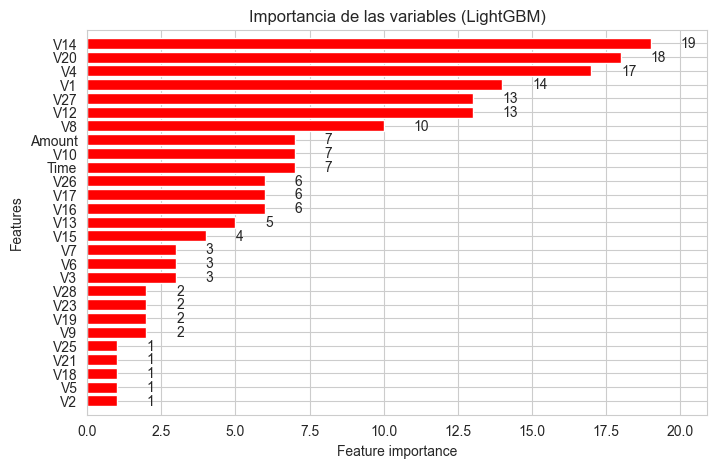

In [66]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
lgb.plot_importance(model, height=0.8, title="Importancia de las variables (LightGBM)", ax=ax,color="red") 
plt.show()


Ahora predigamos el objetivo para los datos de prueba.

### Predecir datos de prueba

In [67]:
preds = model.predict(test_df[predictors])


### Área bajo la curva

Calculemos la puntuación ROC-AUC para la predicción.

In [68]:
roc_auc_score(test_df[target].values, preds)

0.9473337202349548


La puntuación ROC-AUC obtenida para el conjunto de prueba es **0,947**.

### Entrenamiento y validación mediante validación cruzada(cross-validation)

Utilicemos ahora la validación cruzada. Usaremos la validación cruzada (KFolds) con 5 pliegues. Los datos se dividen en 5 pliegues y, por rotación, entrenamos con 4 pliegues (n-1) y validamos con el quinto (n-ésimo).

El conjunto de prueba se calcula como el promedio de las predicciones.

In [70]:
# EXPLICACIÓN DE LOS CAMBIOS (VERSIÓN LGBM 4.0+):
# lgb.early_stopping: Ahora el frenado temprano se define como un callback dentro de la función fit.
# lgb.log_evaluation: El antiguo parámetro 'verbose' ahora se gestiona con este callback.
# Se eliminan 'verbose' y 'early_stopping_rounds' como argumentos directos de .fit().

kf = KFold(n_splits = NUMBER_KFOLDS, random_state = RANDOM_STATE, shuffle = True)

# Crear arrays y dataframes para almacenar resultados
oof_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
n_fold = 0

for train_idx, valid_idx in kf.split(train_df):
    train_x, train_y = train_df[predictors].iloc[train_idx], train_df[target].iloc[train_idx]
    valid_x, valid_y = train_df[predictors].iloc[valid_idx], train_df[target].iloc[valid_idx]
    
    model = LGBMClassifier(
                  nthread=-1,
                  n_estimators=2000,
                  learning_rate=0.01,
                  num_leaves=80,
                  colsample_bytree=0.98,
                  subsample=0.78,
                  reg_alpha=0.04,
                  reg_lambda=0.073,
                  subsample_for_bin=50,
                  boosting_type='gbdt',
                  is_unbalance=False,
                  min_split_gain=0.025,
                  min_child_weight=40,
                  min_child_samples=510,
                  objective='binary',
                  metric='auc',
                  # quitamos silent y verbose de aquí si daban problemas
                  verbose=-1)
    
    # ENTRENAMIENTO CORREGIDO PARA v4.0+
    model.fit(
        train_x, train_y, 
        eval_set=[(valid_x, valid_y)], # Usualmente solo se evalúa sobre el set de validación
        eval_metric='auc',
        callbacks=[
            lgb.early_stopping(stopping_rounds=EARLY_STOP),
            lgb.log_evaluation(period=VERBOSE_EVAL)
        ]
    )
    
    oof_preds[valid_idx] = model.predict_proba(valid_x, num_iteration=model.best_iteration_)[:, 1]
    test_preds += model.predict_proba(test_df[predictors], num_iteration=model.best_iteration_)[:, 1] / kf.n_splits
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = predictors
    fold_importance_df["importance"] = model.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    
    del model, train_x, train_y, valid_x, valid_y
    gc.collect()
    n_fold = n_fold + 1

train_auc_score = roc_auc_score(train_df[target], oof_preds)
print('Full AUC score %.6f' % train_auc_score)

Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.990201
[100]	valid_0's auc: 0.992925
[150]	valid_0's auc: 0.997586
[200]	valid_0's auc: 0.997987
[250]	valid_0's auc: 0.998143
Early stopping, best iteration is:
[231]	valid_0's auc: 0.998184
Fold  1 AUC : 0.998184
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.963933
Early stopping, best iteration is:
[44]	valid_0's auc: 0.966302
Fold  2 AUC : 0.966302
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.937209
[100]	valid_0's auc: 0.938327
[150]	valid_0's auc: 0.939771
[200]	valid_0's auc: 0.942898
[250]	valid_0's auc: 0.942886
Early stopping, best iteration is:
[202]	valid_0's auc: 0.943196
Fold  3 AUC : 0.943196
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.988765
[100]	valid_0's auc: 0.992088
Early stopping, best iteration is:
[69]	valid_0's auc: 0.993275
Fold  4 AUC : 0.993275
Training until valid

### Conclusión de los resultados
El modelo ha completado su entrenamiento utilizando validación cruzada de 5 pliegues (5-Fold CV) con un rendimiento global sobresaliente. Aquí tienes los puntos clave:

Puntuación Final (Full AUC): 0.9703. Esto indica que el modelo es excelente; tiene un 97% de probabilidad de distinguir correctamente entre las clases positiva y negativa.

Consistencia Alta: En casi todos los "folds" (divisiones de datos), el AUC fue superior a 0.94. Esto significa que el modelo es robusto y no depende de la suerte de cómo se dividieron los datos.

Variabilidad entre Folds: * El Fold 1 fue el mejor (0.998), casi perfecto.

El Fold 3 fue el "más difícil" (0.943), lo cual es normal y muestra que el modelo aún así se mantiene sólido en escenarios menos favorables.

Efectividad del Early Stopping: El entrenamiento se detuvo en momentos muy distintos (desde la iteración 44 hasta la 231). Esto evitó que el modelo perdiera tiempo "aprendiendo de memoria" los datos y se quedara con la mejor versión posible de cada fold.

In [71]:
pred = test_preds

# <a id="7">Conclusión Final</a>


Hemos investigado los datos, comprobando el desequilibrio de las clases, visualizando las características y comprendiendo la relación entre ellas. Posteriormente, investigamos varios modelos predictivos utilizando una división de datos en entrenamiento, validación y prueba.

1. **Random Forest:** Obtuvimos una puntuación AUC de **0.852**.
2. **AdaBoost:** Mostró un rendimiento inferior con un AUC de **0.813**.
3. **CatBoost:** Alcanzó un **0.857** tras 500 iteraciones.
4. **XGBoost:** Utilizando el conjunto de validación, logramos un AUC de **0.984** en validación y **0.971** en la predicción final de prueba.
5. **LightGBM:** Mediante validación cruzada (Cross-Validation), el modelo demostró su máxima eficacia con un AUC de **0.970** para la detección de transacciones fraudulentas.

En conclusión, los métodos de ensamble de gradiente, especialmente cuando se combinan con técnicas de validación robustas, ofrecen los mejores resultados para la detección de fraude en este dataset.

# <a id="8">References</a>

### Referencias

[1] Base de datos de detección de fraude en tarjetas de crédito, Transacciones anonimizadas etiquetadas como fraudulentas o legítimas
[2] Análisis de Componentes Principales (PCA), Página de Wikipedia, https://es.wikipedia.org/wiki/Análisis_de_componentes_principales  
[3] Clasificador Random Forest (Bosques Aleatorios), http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html  
[4] Característica ROC-AUC (Área bajo la curva), https://es.wikipedia.org/wiki/Curva_ROC#Área_bajo_la_curva_(AUC)  
[5] Clasificador AdaBoost, http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html  
[6] Clasificador CatBoost, https://tech.yandex.com/catboost/doc/dg/concepts/python-reference_catboostclassifier-docpage/  
[7] Referencia de la API de Python para XGBoost, http://xgboost.readthedocs.io/en/latest/python/python_api.html  
[8] Implementación de LightGBM en Python, https://github.com/Microsoft/LightGBM/tree/master/python-package  
[9] Algoritmo LightGBM (Documento técnico), https://www.microsoft.com/en-us/research/wp-content/uploads/2017/11/lightgbm.pdf

